In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
import torch

from counterfactuals.datasets import AdultDataset
from counterfactuals.datasets.adult import DequantizationTransformer

# from counterfactuals.dequantization import DequantizationOriginal
from counterfactuals.generative_models import MaskedAutoregressiveFlow
from counterfactuals.discriminative_models import LogisticRegression
from counterfactuals.generative_models.dequantization import Dequantization
from counterfactuals.generative_models.variational_dequantization import (
    VariationalDequantization,
)
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

# Dataset dequantization

In [12]:
dataset = AdultDataset("../data/adult.csv")
dataset.categorical_columns

[2, 3, 4, 5, 6, 7]

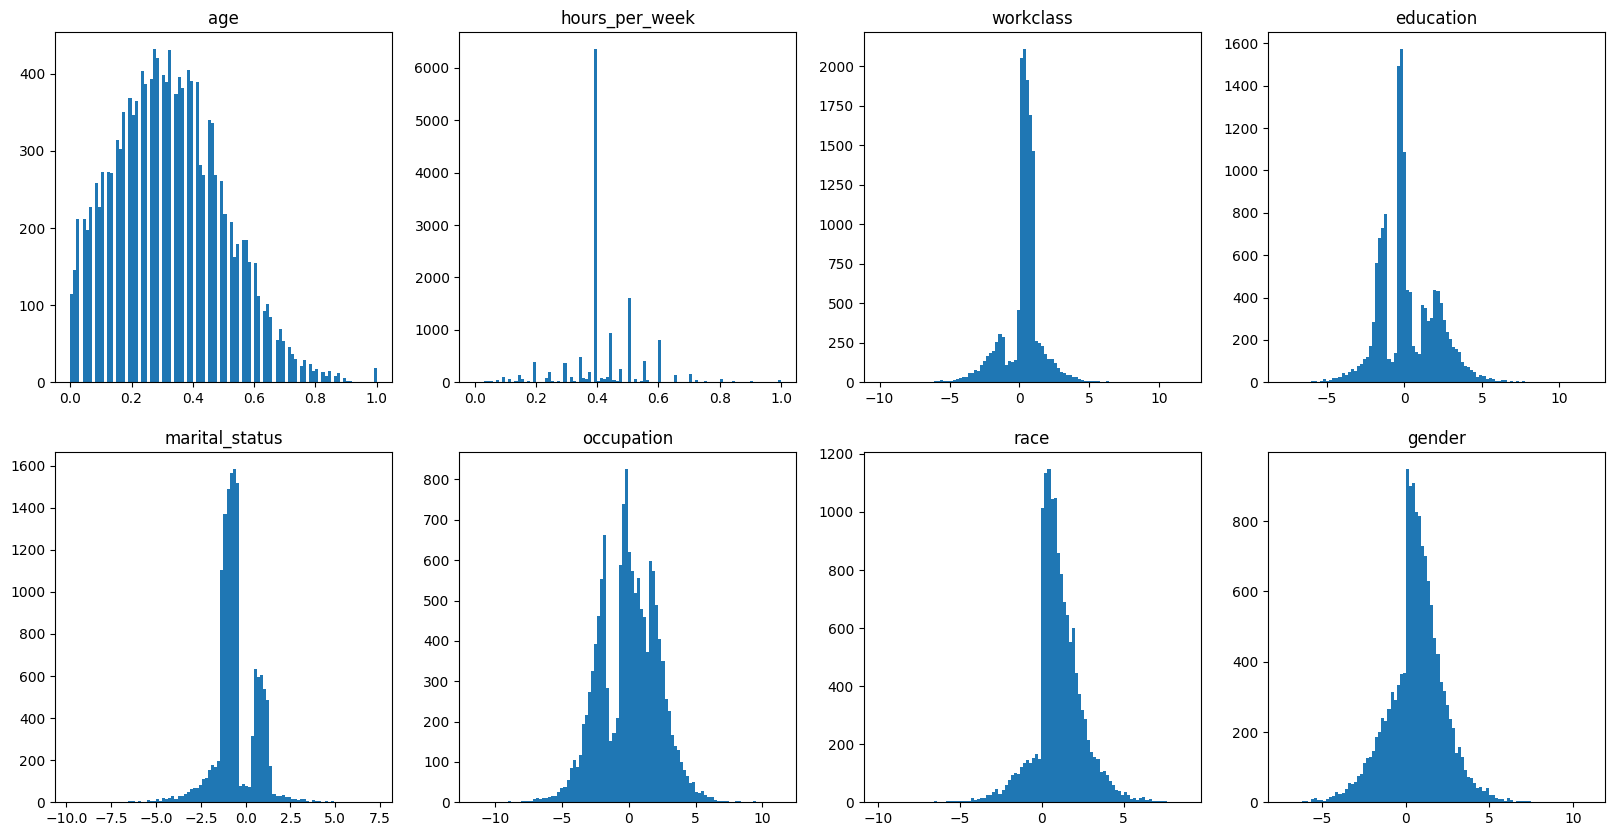

In [13]:
plt.figure(figsize=(20, 10))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.title(dataset.feature_columns[i])
    plt.hist(dataset.X_train[:, i], bins=100)

In [ ]:
disc_model = LogisticRegression(
    input_size=dataset.X_train.shape[1],
    target_size=1,
    category_counts=[len(cat) for cat in dataset.categorical_features_lists],
    category_indices=dataset.categorical_columns,
)

disc_model.fit(
    train_loader=dataset.train_dataloader(128, True),
    epochs=500,
    lr=3e-4,
)

y_pred = disc_model.predict(dataset.X_test)

print(classification_report(dataset.y_test, y_pred))

In [10]:
quants = [len(cat) for cat in dataset.categorical_features_lists]

gen_model = MaskedAutoregressiveFlow(
    features=dataset.X_test.shape[1],
    hidden_features=32,
    context_features=1,
    category_counts=quants,
    category_indices=dataset.categorical_columns,
)

gen_model.fit(
    train_loader=dataset.train_dataloader(2048, True),
    test_loader=dataset.test_dataloader(2048, False),
    num_epochs=500,
    learning_rate=1e-3,
)

ll_pred_zero = gen_model.log_prob_(
    dataset.X_test, torch.zeros(dataset.X_test.shape[0], 1)
)
ll_pred_one = gen_model.log_prob_(
    dataset.X_test, torch.ones(dataset.X_test.shape[0], 1)
)
y_pred = ll_pred_zero < ll_pred_one
print(classification_report(dataset.y_test, y_pred))

gen_model.log_prob_(
    torch.from_numpy(dataset.X_test[:10]), torch.from_numpy(dataset.y_test[:10])
).mean()

Epoch 499, Train: 20.7104, test: 9.9551: 100%|██████████| 500/500 [01:30<00:00,  5.54it/s] 

              precision    recall  f1-score   support

         0.0       0.59      0.67      0.63       785
         1.0       0.62      0.54      0.58       784

    accuracy                           0.60      1569
   macro avg       0.61      0.60      0.60      1569
weighted avg       0.61      0.60      0.60      1569



tensor(-8.8311, grad_fn=<MeanBackward0>)

# Flow dequantization

In [28]:
n_samples = 10**3
Xs = torch.hstack(
    [torch.randint(0, 5, (n_samples, 1)), torch.randint(0, 8, (n_samples, 1))]
)
print(Xs.shape)
# ys = (Xs[:, 0] == Xs[:, 1])
ys_true = torch.tensor(
    [(f1 % 2 == 0 and f2 < 4) or (f1 % 2 != 0 and f2 >= 4) for f1, f2 in Xs],
    dtype=torch.int32,
)
ys = ys_true.clone()
ys[torch.rand(n_samples) < 0.1] = 1

Xs = Xs.type(torch.float32)
ys = ys.type(torch.float32)

# create torch tensor dataset and dataloader from Xs
dataset = torch.utils.data.TensorDataset(Xs, ys)
dl = torch.utils.data.DataLoader(dataset, batch_size=2048)

torch.Size([1000, 2])


In [12]:
n_samples = 10**3
Xs = torch.randint(0, 2, (n_samples, 2))
print(Xs.shape)
ys = Xs[:, 0] == Xs[:, 1]
# ys_true = torch.tensor([(f1 % 2 == 0 and f2 < 4) or (f1 % 2 != 0 and f2 >= 4) for f1, f2 in Xs], dtype=torch.int32)
# ys = ys_true.clone()
# ys[torch.rand(n_samples) < 0.1] = 1

Xs = Xs.type(torch.float32)
ys = ys.type(torch.float32)

# create torch tensor dataset and dataloader from Xs
dataset = torch.utils.data.TensorDataset(Xs, ys)
dl = torch.utils.data.DataLoader(dataset, batch_size=2048)

torch.Size([1000, 2])


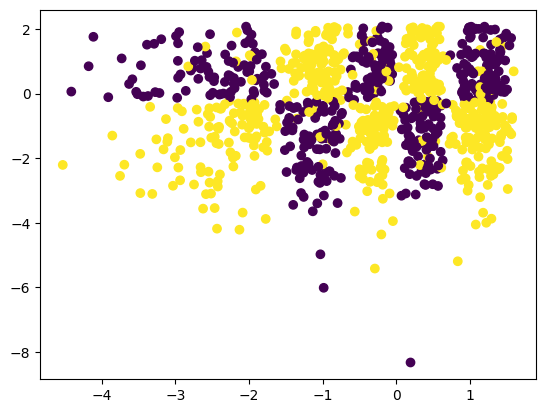

In [29]:
deq = VariationalDequantization(
    category_counts=[5, 8],
    category_indices=[0, 1],
    features=2,
    hidden_features=16,
    context_features=2,
)
xs_deq, _ = deq(Xs, ys)
xs_deq = xs_deq.detach().numpy()
plt.scatter(xs_deq[:, 0], xs_deq[:, 1], c=ys)

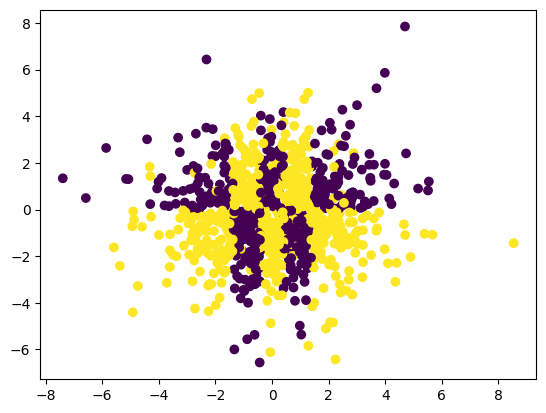

In [30]:
deq = Dequantization(category_counts=[5, 8], category_indices=[0, 1])
xs_deq, _ = deq(Xs, ys)
plt.scatter(xs_deq[:, 0], xs_deq[:, 1], c=ys)

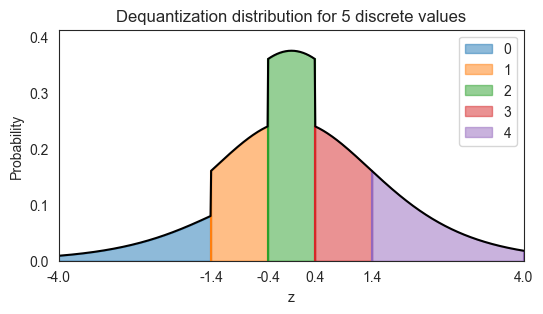

In [9]:
import numpy as np
import seaborn as sns
from matplotlib.colors import to_rgb
import matplotlib.pyplot as plt


def visualize_dequantization(quants, prior=None):
    """
    Function for visualizing the dequantization values of discrete values in continuous space
    """
    # Prior over discrete values. If not given, a uniform is assumed
    if prior is None:
        prior = np.ones(quants, dtype=np.float32) / quants
    prior = prior / prior.sum()  # Ensure proper categorical distribution

    inp = torch.arange(-4, 4, 0.01).view(
        -1, 1
    )  # Possible continuous values we want to consider
    ldj = torch.zeros(inp.shape[0])
    dequant_module = Dequantization(category_counts=[quants], category_indices=[0])
    # Invert dequantization on continuous values to find corresponding discrete value
    # out, ldj = dequant_module.forward(inp, ldj, reverse=True)
    out, ldj = dequant_module.inverse(inp, None)
    inp, out, prob = (
        inp.squeeze().numpy(),
        out.squeeze().numpy().astype(int),
        ldj.exp().numpy(),
    )
    prob = prob * prior[out]  # Probability scaled by categorical prior

    # Plot volumes and continuous distribution
    sns.set_style("white")
    plt.figure(figsize=(6, 3))
    x_ticks = []
    for v in np.unique(out):
        indices = np.where(out == v)
        color = to_rgb(f"C{v}")
        plt.fill_between(
            inp[indices],
            prob[indices],
            np.zeros(indices[0].shape[0]),
            color=color + (0.5,),
            label=str(v),
        )
        plt.plot([inp[indices[0][0]]] * 2, [0, prob[indices[0][0]]], color=color)
        plt.plot([inp[indices[0][-1]]] * 2, [0, prob[indices[0][-1]]], color=color)
        x_ticks.append(inp[indices[0][0]])
    x_ticks.append(inp.max())
    plt.xticks(x_ticks, [f"{x:.1f}" for x in x_ticks])
    plt.plot(inp, prob, color=(0.0, 0.0, 0.0))
    # Set final plot properties
    plt.ylim(0, prob.max() * 1.1)
    plt.xlim(inp.min(), inp.max())
    plt.xlabel("z")
    plt.ylabel("Probability")
    plt.title(f"Dequantization distribution for {quants} discrete values")
    plt.legend()
    plt.show()
    plt.close()


visualize_dequantization(quants=5, prior=np.array([0.1, 0.2, 0.3, 0.2, 0.2]))

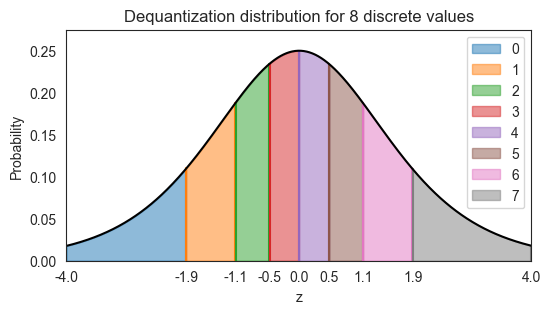

In [10]:
visualize_dequantization(quants=8)

In [24]:
# quants = [len(cat) for cat in dataset.categorical_features_lists]
quants = [2, 2]
category_indices = [0, 1]

gen_model = MaskedAutoregressiveFlow(
    features=2,
    hidden_features=16,
    num_layers=2,
    context_features=1,
    category_counts=quants,
    category_indices=category_indices,
)

In [25]:
gen_model.fit(
    train_loader=dl,
    test_loader=dl,
    num_epochs=5000,
    learning_rate=1e-3,
)

Epoch 4999, Train: -14.7404, test: -14.8350: 100%|██████████| 5000/5000 [01:03<00:00, 78.61it/s]


In [27]:
gen_model.sample(10, context=torch.zeros(1, 1))

tensor([[[0., 0.],
         [1., 0.],
         [0., 0.],
         [0., 1.],
         [0., 0.],
         [1., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [1., 0.]]], grad_fn=<ViewBackward0>)

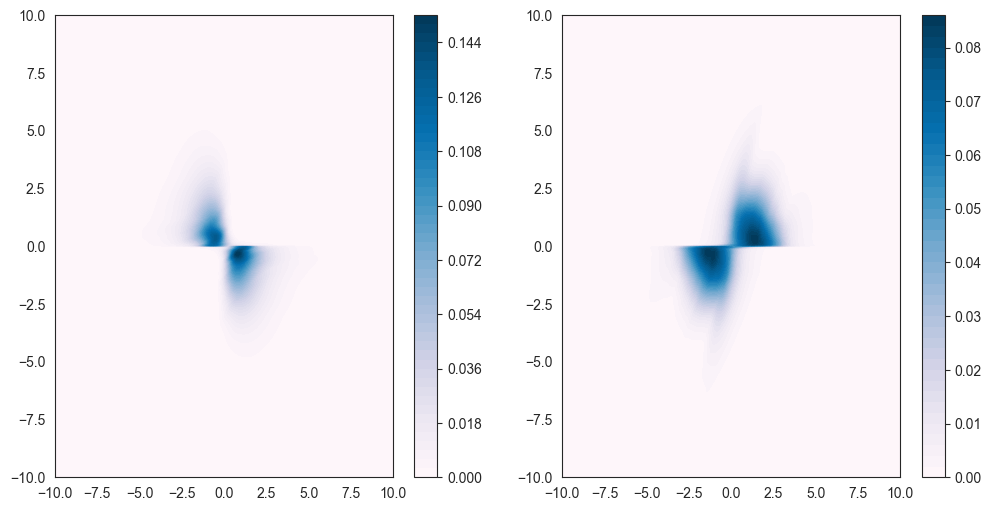

In [14]:
import matplotlib.cm as cm

# fig, ax = plt.subplots(1, 1)
# fig.set_size_inches(8, 6)

lat_size = 300
xline = torch.linspace(-10, 10, lat_size)
yline = torch.linspace(-10, 10, lat_size)
xgrid, ygrid = torch.meshgrid(xline, yline)
xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

with torch.no_grad():
    zgrid_0 = (
        gen_model.log_prob_(
            xyinput, torch.zeros(lat_size**2, 1), without_dequantization=True
        )
        .exp()
        .reshape(lat_size, lat_size)
    )
    zgrid_1 = (
        gen_model.log_prob_(
            xyinput, torch.ones(lat_size**2, 1), without_dequantization=True
        )
        .exp()
        .reshape(lat_size, lat_size)
    )

zgrid_0 = zgrid_0.numpy()
zgrid_1 = zgrid_1.numpy()

# make contourf subplots for each class


fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 6)
cs = ax[0].contourf(
    xgrid.numpy(),
    ygrid.numpy(),
    zgrid_0,
    levels=50,
    cmap=cm.PuBu,  # locator=ticker.LogLocator()
)

cbar = fig.colorbar(cs)  # noqa: F841

cs = ax[1].contourf(
    xgrid.numpy(),
    ygrid.numpy(),
    zgrid_1,
    levels=50,
    cmap=cm.PuBu,  # locator=ticker.LogLocator()
)
cbar = fig.colorbar(cs)  # noqa: F841

# plt.show()

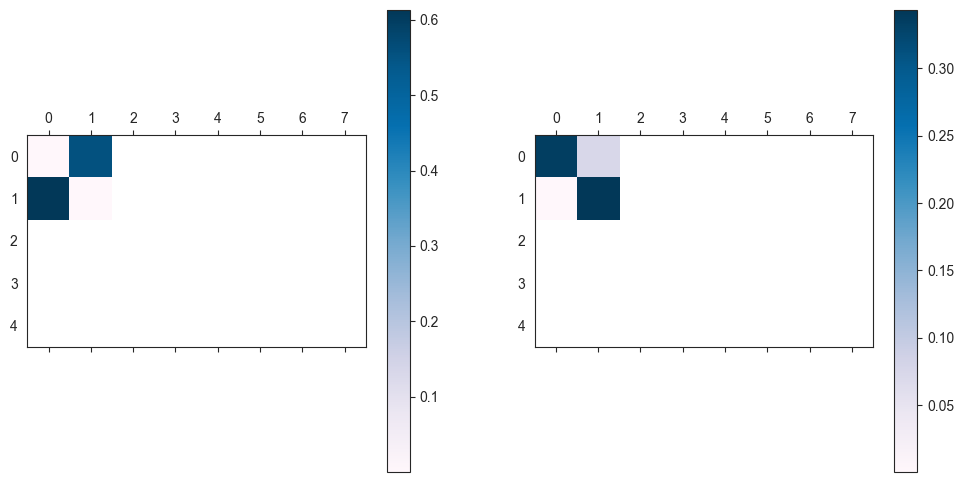

In [15]:
import matplotlib.cm as cm

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 6)

lat_size = 300
xline = torch.linspace(0, 4, 5)
yline = torch.linspace(0, 7, 8)
xgrid, ygrid = torch.meshgrid(xline, yline)
xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

with torch.no_grad():
    zgrid_0 = gen_model.log_prob(xyinput, torch.zeros(5 * 8, 1)).exp().reshape(5, 8)
    zgrid_1 = gen_model.log_prob(xyinput, torch.ones(5 * 8, 1)).exp().reshape(5, 8)

zgrid_0 = zgrid_0.numpy()
zgrid_1 = zgrid_1.numpy()

cs = ax[0].matshow(zgrid_0, cmap=cm.PuBu)
cbar = fig.colorbar(cs)  # noqa: F841
cs = ax[1].matshow(zgrid_1, cmap=cm.PuBu)
cbar = fig.colorbar(cs)  # noqa: F841
plt.show()

In [19]:
ll_pred_zero = gen_model.log_prob_(Xs, torch.zeros(Xs.shape[0], 1))
ll_pred_one = gen_model.log_prob_(Xs, torch.ones(Xs.shape[0], 1))

In [20]:
y_pred = ll_pred_zero < ll_pred_one

In [21]:
print(classification_report(ys, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       503
         1.0       1.00      1.00      1.00       497

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



In [ ]:
dataset = AdultDataset("../data/adult.csv")
dataset.categorical_columns

In [5]:
transformer = DequantizationTransformer(
    category_counts=[len(cat) for cat in dataset.categorical_features_lists],
    category_indices=dataset.categorical_columns,
)

In [6]:
dataset.X_train = transformer.fit_transform(dataset.X_train)
dataset.X_test = transformer.transform(dataset.X_test)

In [41]:
quants = [len(cat) for cat in dataset.categorical_features_lists]


gen_model = MaskedAutoregressiveFlow(
    features=dataset.X_test.shape[1],
    hidden_features=32,
    context_features=1,
    category_counts=quants,
    category_indices=dataset.categorical_columns,
)

In [42]:
gen_model.fit(
    train_loader=dataset.train_dataloader(2048, True),
    test_loader=dataset.test_dataloader(2048, False),
    num_epochs=500,
    learning_rate=1e-3,
)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 499, Train: 8.8727, test: 8.9354: 100%|██████████| 500/500 [01:18<00:00,  6.35it/s]  


In [43]:
ll_pred_zero = gen_model.log_prob_(
    dataset.X_test, torch.zeros(dataset.X_test.shape[0], 1)
)
ll_pred_one = gen_model.log_prob_(
    dataset.X_test, torch.ones(dataset.X_test.shape[0], 1)
)
y_pred = ll_pred_zero < ll_pred_one
print(classification_report(dataset.y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.80      0.70      0.75       785
         1.0       0.73      0.82      0.78       784

    accuracy                           0.76      1569
   macro avg       0.77      0.76      0.76      1569
weighted avg       0.77      0.76      0.76      1569



In [44]:
gen_model.log_prob_(
    torch.from_numpy(dataset.X_test[:10]), torch.from_numpy(dataset.y_test[:10])
).exp()

tensor([5.9895e-04, 1.3918e-04, 6.8646e-04, 1.3947e-03, 1.5779e-03, 2.4826e-04,
        3.2534e-06, 2.3165e-03, 1.1170e-03, 2.5253e-04],
       grad_fn=<ExpBackward0>)

In [16]:
gen_model(
    torch.from_numpy(dataset.X_test[:10]), torch.from_numpy(dataset.y_test[:10])
).exp()

tensor([1.6801e-04, 1.9023e+01, 1.1569e+04, 1.0708e+04, 7.6580e+04, 5.5666e+02,
        2.7540e-04, 1.6459e+04, 8.4886e-04, 8.6580e+03],
       grad_fn=<ExpBackward0>)

In [14]:
disc_model = LogisticRegression(
    input_size=dataset.X_train.shape[1],
    target_size=1,
    category_counts=[len(cat) for cat in dataset.categorical_features_lists],
    category_indices=dataset.categorical_columns,
)

disc_model.fit(
    train_loader=dataset.train_dataloader(128, True),
    epochs=500,
    lr=1e-3,
)

Epoch 499, Loss: 0.5483: 100%|██████████| 500/500 [00:22<00:00, 22.55it/s]


In [15]:
y_pred = disc_model.predict(dataset.X_test)

print(classification_report(dataset.y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.72      0.68      0.70       785
         1.0       0.70      0.73      0.72       784

    accuracy                           0.71      1569
   macro avg       0.71      0.71      0.71      1569
weighted avg       0.71      0.71      0.71      1569

